<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/DensenetImplementation_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x  # for colab
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.utils import np_utils
import tensorboard

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # for colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [0]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
x_train = x_train/255.0
x_test = x_test/255.0

batch_size = 64
image_generator = ImageDataGenerator(rotation_range=10,
                                     width_shift_range=0.2,
                                     height_shift_range=0.1,
                                     horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
image_generator.fit(x_train)
#image_generator.fit(x_test)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
 x_train.shape

(50000, 32, 32, 3)

In [0]:
x_test.shape

(10000, 32, 32, 3)

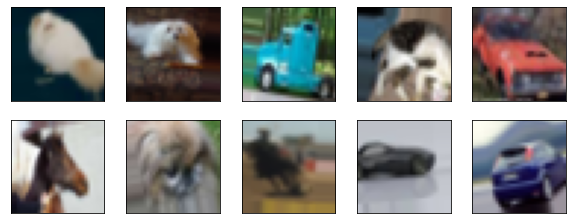

In [0]:
for X_batch, y_batch in image_generator.flow(x_train, y_train, batch_size=10):
  plt.figure(figsize=(10,10))
  for i in range(0,10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
  plt.show()
  break

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

from tensorflow.keras.regularizers import l2

In [0]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [0]:
def plotAccuracies(history):  
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')
    plt.show()

Dense Block Example

In [0]:
def transition(x, concat_axis, nb_filter,
               dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, RELU 1x1 Convolution, averagePooling, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (1, 1),
               kernel_initializer="he_uniform",
               padding="same",
               use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x


In [0]:
def conv_block(x, concat_axis, nb_filter,
                 dropout_rate=None, weight_decay=1E-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    x1 = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(nb_filter, (3, 3),
               kernel_initializer="he_uniform",
               activation=tf.nn.relu,
               padding="same",
               use_bias=False,
               kernel_regularizer=l2(weight_decay))(x1)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    x = Concatenate(axis=concat_axis)([x, x1])
    return x

In [0]:
def denseblock(x, concat_axis, nb_layers, nb_filter, growth_rate,
               dropout_rate=None, weight_decay=1E-4):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''       
    for num in range(nb_layers):
        x = conv_block(x, concat_axis, nb_filter,
                         dropout_rate, weight_decay)
    nb_filter += growth_rate

    return x, nb_filter

In [0]:

def DenseNet(nb_classes, img_dim, nb_layers, nb_dense_block, growth_rate,
             nb_filter, dropout_rate=None, weight_decay=1E-4):
    '''Instantiate the DenseNet  architecture,
        # Arguments
            nb_dense_block: number of dense blocks to add to end
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters
            reduction: reduction factor of transition blocks.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            classes: optional number of classes to classify images
            weights_path: path to pre-trained weights
        # Returns
            A Keras model instance.
    '''
    #Build the DenseNet model
  
    if tf.keras.backend.image_data_format() == "channels first":
        concat_axis = 1
    else:
        concat_axis = -1

    model_input = tf.keras.layers.Input((img_dim))

    # Initial convolution
    x = Conv2D(nb_filter, (3, 3),
               kernel_initializer="he_uniform",
               padding="same",
               name="initial_conv2D",
               use_bias=False,
               kernel_regularizer=l2(weight_decay))(model_input)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = denseblock(x, concat_axis, nb_layers,
                                  nb_filter, growth_rate, 
                                  dropout_rate=dropout_rate,
                                  weight_decay=weight_decay)
        # add transition
        x = transition(x, concat_axis, nb_filter, dropout_rate=dropout_rate,
                       weight_decay=weight_decay)

    # The last denseblock does not have a transition
    x, nb_filter = denseblock(x, concat_axis, nb_layers,
                              nb_filter, growth_rate, 
                              dropout_rate=dropout_rate,
                              weight_decay=weight_decay)

    x = BatchNormalization(axis=concat_axis,
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D(data_format=tf.keras.backend.image_data_format())(x)
    x = Dropout(0.5)(x) 
    x = Dense(nb_classes,
              activation='softmax',
              kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(x)

    densenet = Model(inputs=[model_input], outputs=[x], name="DenseNet")

    return densenet

Hyperparameters for cifar10

- Dense blocks: consists of BN-RELU-Dropout layer outputs concatenated at channel level. 
- Transition/Bottleneck block : input(feature maps) to deeper layers keeps increasing paramters which makes the model more complex. So transition blocks reduces the dimension of output form dense blocks by a factor of 2 using BatchNorm, RELU 1x1 Convolution, averagePooling and dropout. It improves computational and parameter learning efficiency
- Growth rate : increases the number of filters per layer



In [0]:
nb_classes=10 #for cifar10
batch_size=64
nb_layers=5 #number of layers in a dense block
nb_dense_block=5 #number of dense blocks
nb_filter=32 #number of filters
growth_rate=32 
dropout_rate=0.2 #dropout rate in the dense blocks
learning_rate=0.1 
weight_decay=1E-4 
img_dim = x_train.shape[1:]
print(img_dim)


(32, 32, 3)


Keras Tensorboard: log data

In [0]:
from datetime import datetime
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

fit method can be used when the entire training dataset can fit into memory and no data augmentation is applied.
 
 fit_generator method can be used when :
- the dataset is too large to fit into memory
- data augmentation needs to be applied
- when it’s more convenient to yield training data in batches (i.e., using the flow_from_directory function)

**High-level Training Loops with Keras**

In [0]:
def run_model(model):
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(
                      image_generator.flow(x_train, y_train,batch_size=batch_size),
                      steps_per_epoch=(len(x_train)/batch_size)*5,
                      epochs=30,
                      validation_data=(x_test, y_test),
                      shuffle=True,
                      callbacks=[tensorboard_callback])
  plotLosses(history)
  plotAccuracies(history)

89% training accuracy and 85.4% test accuracy for 30 epochs

Advantages of having dense blocks(performs concatenation) as compared to residual blocks(performs addition) : 
- During backpropagation, gradients can be easily propagated back to earlier layers of the network, so they get more direct supervision from the final classification layer
- Since input to each layer is concatenation of outputs from preceding layers, so it learns more diversified features which tend to have richer patterns.
- In normal conv net, features are more compact and high level as it composes many non-linear transformations. Whereas in Dense net, it maintains low complexity features across the network. It learns both simple and complex features together which lets the classifier learn more smooth decision boundaries. So, densenet can learn well even in case of less training data
- Fewer paramters to learn -> computationally efficient

Reference : 
-https://arxiv.org/pdf/1608.06993v3.pdf

Model: "DenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

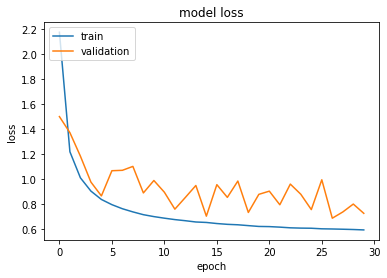

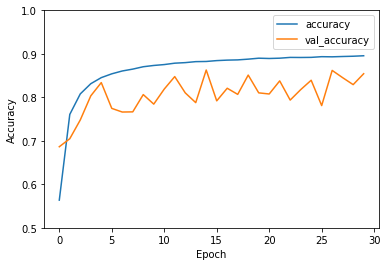

In [0]:
 #invoke densenet
model = DenseNet(num_classes, img_dim, nb_layers, nb_dense_block, growth_rate, nb_filter, dropout_rate=dropout_rate,
                    weight_decay=weight_decay)
run_model(model)

In [0]:
%tensorboard --logdir logs